In [1]:
%run GameInterface.ipynb
from ipycanvas import Canvas,hold_canvas,MultiCanvas
import numpy as np


PLAYER1='1'
PLAYER2='2'

NRow=8
NColumn=8

DARK_SQUARE='0'
WHITE_SQUARE='_'

SquareSize=50

CWIDTH=400
BoardSize=400
PieceDiameter=23

canvas = Canvas(width=CWIDTH*2, height=CWIDTH)

class Draughts(Game):
    
    def __init__(self,player):
        self.current_player = PLAYER1
        self.board = self.generateGameBoard()
        
    def generateGameBoard(self):
        blankBorad=[[(WHITE_SQUARE if y%2==0 else DARK_SQUARE )if x%2==0 else (DARK_SQUARE if y%2==0 else WHITE_SQUARE) for y in range(NColumn)] for x in range(NRow)]
        #init two players pieces , 12 on each side.
        for x in range(3):
            for y in range(NColumn):
                if blankBorad[x][y]==DARK_SQUARE:
                    blankBorad[x][y]=PLAYER1
                if blankBorad[(x+1)*-1][y]==DARK_SQUARE:
                    blankBorad[(x+1)*-1][y]=PLAYER2
        return blankBorad
        
    
    def update(self,newstate,pos):
        self.current_player= PLAYER1 if self.current_player==PLAYER2 else PLAYER2
        self.board=newstate
    
    def getMoves(self):
        self.Movement()
        return []
    
    def isGameOver(self):
        v=self.checkWhoWon(self.board)
        if  v== PLAYER1 or v==PLAYER2:
            return True
        else:
            return False
    
    def checkWhoWon(self,cur):
        cur=np.array(cur)
        #A player wins by capturing all of the opponent's pieces 
        if not (cur==PLAYER1).any() and not (cur==PLAYER1+PLAYER1).any():
            #player 2 won
            return PLAYER2
        if not (cur==PLAYER2).any() and not (cur==PLAYER2+PLAYER2).any():
            #player 1 won
            return PLAYER1
        #or by leaving the opponent with no legal move
        if len(self.Movement(cur,PLAYER1))>0 and len(self.Movement(cur,PLAYER2))==0:
            return PLAYER1
        if len(self.Movement(cur,PLAYER2))>0 and len(self.Movement(cur,PLAYER1))==0:
            return PLAYER1
        return 0
    
    def getWinner(self):
        return self.checkWhoWon(self.board)
    
    def clone(self):
        pass
    
    def drawGame(self):
        pass
    
        #emnpty the captured square and move the piece
    def capture(self,cur,srcPos,destPos,capturedPos):
        cur[capturedPos[0]][capturedPos[1]]=DARK_SQUARE
        cur[destPos[0]][destPos[1]]=cur[srcPos[0]][srcPos[1]]
        cur[srcPos[0]][srcPos[1]]=DARK_SQUARE
        return cur

    #check the specific piece is valid
    def checkValidPos(self,curState,pos):
        srcPos=pos
        if srcPos[0]<0 or srcPos[0] >= NRow:
            return False
        if srcPos[1]<0 or srcPos[1]>= NColumn:
            return False
        if curState[srcPos[0]][srcPos[1]]!=DARK_SQUARE:
            return False
        return True

    jumpAct=np.array([[-1,-1],[-1,1],[1,-1],[1,1]])

    #stop recursing when reach the king row or cannot jump
    #return 3 dimensions list, [[[x,y]*9]*8] with posiiton details.
    def jump(self,cur,pos,player,isking=False):
        newState=list()
        if not isking:
            if (player==PLAYER1 and pos[0]==NRow-1) or (player==PLAYER2 and pos[0]==0):
                #check if is already being crowned
                if cur[pos[0]][pos[1]]!=PLAYER1+PLAYER1 and cur[pos[0]][pos[1]]!= PLAYER2+PLAYER2:
                    #crown this man and stop jumping
                    newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                    newCur[pos[0]][pos[1]]+=newCur[pos[0]][pos[1]] # 11 or 22
                    newCur.append([pos,pos])
                    newState.append(newCur)
                    return newState
            #scan 4 direction which is diagonally adjacent an opponent's piece.
            for act in self.jumpAct:
                oppoPiecePos=pos+act
                destPos=pos+act+act
                if self.checkValidPos(cur,destPos):
                    #opponent's piece exist
                    oppoPlayer=PLAYER1 if player==PLAYER2 else PLAYER2
                    if cur[oppoPiecePos[0]][oppoPiecePos[1]]==oppoPlayer:
                        newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                        newSubCurState=capture(newCur,pos,destPos,oppoPiecePos)
                        newSubCurState.append([pos,destPos.tolist()])
                        newState.append(newSubCurState)
                        c=self.jump(newSubCurState[:NRow],destPos.tolist(),player,isking)
                        if c!=[]:
                            for x in c:
                                newState.append(x)
            return newState 
        else:
            #king jumping 
            oppoPlayer=PLAYER1 if player==PLAYER2 else PLAYER2
            for act in self.jumpAct:
                #the maximum mumber of squares in diagonal direction less than 8, so 8 times can cover every squares.
                for i in range(2,8):
                    oppoPiecePos=pos+act*i-act
                    destPos=pos+act*i
                    destPos=destPos.tolist()
                    #check if valid of landing position, then see if opponent's piece exist.
                    if self.checkValidPos(cur,destPos):
                        if cur[oppoPiecePos[0]][oppoPiecePos[1]]==oppoPlayer:
                            newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                            newSubCurState=capture(newCur,pos,destPos,oppoPiecePos)
                            newSubCurState.append([pos,destPos])
                            #explore reamining empty squares once jump(any possibility to jump again in this line)
                            jumpPos=list()
                            for vi in range(i,NRow):
                                destPos2=pos+act*vi
                                destPos2=destPos2.tolist()
                                #skip the first position where piece land on in last jump and continue to scan
                                if destPos2!=destPos:
                                    if self.checkValidPos(newSubCurState,destPos2):
                                        jumpPos=self.jump(newSubCurState[:NRow],destPos2,player,isking)
                                else:
                                    jumpPos=self.jump(newSubCurState[:NRow],destPos2,player,isking)
                                    if jumpPos!=[]:
                                        #update pos
                                        jumpPos=jumpPos[0]
                                        #there are multi jump after first jumping, default action is first one(not required)
                                        jumpPos[NRow][0]=pos[:]
                                        newSubCurState=jumpPos
                            newState.append(newSubCurState)
                        elif cur[oppoPiecePos[0]][oppoPiecePos[1]]==player:
                            break
            return newState


    moveForwardAct=[[-1,-1],[-1,1]]
    moveBackAct=[[1,-1],[1,1]]
    # pos is current piece scaned
    def simpleMove(self,cur,pos,player,isking=False):
        newState=[]
        acts=self.moveBackAct if player==PLAYER1 else self.moveForwardAct
        if not isking:
            for act in np.array(acts):
                newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                destPos=pos+act
                if self.checkValidPos(newCur,destPos):
                    #new board state
                    newCur[destPos[0]][destPos[1]]=newCur[pos[0]][pos[1]]
                    newCur[pos[0]][pos[1]]=DARK_SQUARE
                    newCur.append([pos,destPos.tolist()])
                    newState.append(newCur)
            return newState    
        else:
            #king moving
            acts=self.moveForwardAct+self.moveBackAct
            acts=np.array(acts)
            newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
            destsPos=[]
            for act in acts:
                #start with current position and move diagonally, stop when obstacle encounter
                for i in range(1,NRow):
                    destPos=pos+act*i
                    if self.checkValidPos(newCur,destPos):
                        #new board state
                        destsPos.append(destPos.tolist())
            #Wherever square AI piece land on do not affect the value of evalFunction,So just choose it randomly.
            #but list all actions for human player
            if player==PLAYER2:
                for subpos in destsPos:
                    newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                    newCur[subpos[0]][subpos[1]]=newCur[pos[0]][pos[1]]
                    newCur[pos[0]][pos[1]]=DARK_SQUARE
                    newCur.append([pos,subpos])
                    newState.append(newCur)
            else:
                destPos=destsPos[np.random.randint(len(destsPos))]
                newCur[destPos[0]][destPos[1]]=newCur[pos[0]][pos[1]]
                newCur[pos[0]][pos[1]]=DARK_SQUARE
                newCur.append([pos,destPos])
                newState.append(newCur)
            return newState

    #check and setup the men who can turn into king
    def Crown(self,cur):
        for j in range(NRow):
            if cur[0][j]==PLAYER2:
                newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                newCur[0][j]+=newCur[0][j] # 11 or 22
                return newCur
            if cur[-1][j]==PLAYER1:
                newCur=[[cur[x][y] for y in range(NColumn)]for x in range(NRow)]
                newCur[-1][j]+=newCur[-1][j] # 11 or 22
                return newCur
        return cur

    #return all available positions
    def ScanAround(self,curState,pos,player):
        #king
        #curState=Crown(curState)
        #jumping detect
        newState=list()
        if curState[pos[0]][pos[1]]==player+player:
            v=self.jump(curState,pos,player,True)
            if v!=[]:
                #newState+=jump(curState,pos,player,True)
                newState+=v
        else:
            v=self.jump(curState,pos,player)
            if v!=[]:
                newState+=v
            #newState+=jump(curState,pos,player)
        #jump is also taken prior to simple move    
        if newState!=[]:
            return newState,True
        #move detect
        #isking
        if curState[pos[0]][pos[1]]==player+player:
            newState+=self.simpleMove(curState,pos,player,True)
        else:
            newState+=self.simpleMove(curState,pos,player)
        return newState,False

    #return every available board states  
    def Movement(self,curState,player):
        #loop every piece
        self.board=curState
        curState=self.Crown(curState)
        newCurState=list()
        jumpNewCurState=list()
        for row in range(NRow):
            for column in range(NColumn):
                if curState[row][column]==player or curState[row][column]==player+player:
                    #check position where can reach
                    newState=[[curState[x][y] for y in range(NColumn)]for x in range(NRow)]
                    c,isJump=self.ScanAround(newState[:NRow],[row,column],player)
                    if c!=[]:
                        if isJump:
                            jumpNewCurState+=c
                        else:                           
                            newCurState+=c
        return newCurState if len(jumpNewCurState)==0 else jumpNewCurState
    
    
    def evalState(self,cur):
        # 1 point for every remaining men
        # 10 point for every remaining king
        # total player 1 - total player 2 
        cur=np.array(cur)
        #Player 1 points 
        mensPoint=(cur==PLAYER1).sum()
        kingsPoint=(cur==PLAYER1+PLAYER1).sum()*10
        p1p=mensPoint+kingsPoint
        #Player 2 points
        mensPoint=(cur==PLAYER2).sum()
        kingsPoint=(cur==PLAYER2+PLAYER2).sum()*10
        p2p=mensPoint+kingsPoint

        #strageties 
        #1. favoring no move when difference between the number of rows of the pieces equal 1
        p1men=np.where(cur==PLAYER1)
        p1king=np.where(cur==PLAYER1+PLAYER1)
        p1TotalPos=(list(zip(p1men[0],p1men[1])))+(list(zip(p1king[0],p1king[1])))

        p2men=np.where(cur==PLAYER2)
        p2king=np.where(cur==PLAYER2+PLAYER2)
        p2TotalPos=(list(zip(p2men[0],p2men[1])))+(list(zip(p2king[0],p2king[1])))
        for p1pos in p1TotalPos:
            for p2pos in p2TotalPos:
                if p1pos[0]-p2pos[0]==1:
                    p1p-=1
        return p1p-p2p

        
def location(x):
    return  x*SquareSize+SquareSize/2

king=4
def RenderGameState(game):
    canvas.clear()
    for i in range(NRow):
        for j in range(NColumn):
            if game.board[i][j]!=WHITE_SQUARE:
                canvas.fill_style='gray'
                canvas.fill_rect(j*SquareSize,i*SquareSize,width=SquareSize)
                #draw piece
                if game.board[i][j]==PLAYER1:
                    canvas.fill_style='red'
                    canvas.fill_circle(location(j),location(i),PieceDiameter)
                if game.board[i][j]==PLAYER2:
                    canvas.fill_style='black'
                    canvas.fill_circle(location(j),location(i),PieceDiameter)
                if game.board[i][j]==PLAYER1+PLAYER1:
                    canvas.fill_style='red'
                    canvas.fill_polygon([(0*king+location(j),2*king+location(i)),
                                         (3*king+location(j),6*king+location(i)),
                                         (5*king+location(j),0*king+location(i)),
                                         (7*king+location(j),6*king+location(i)),
                                         (10*king+location(j),2*king+location(i)),
                                         (9*king+location(j),10*king+location(i)),
                                         (1*king+location(j),10*king+location(i))])
                if game.board[i][j]==PLAYER2+PLAYER2:
                    canvas.fill_style='black'
                    canvas.fill_polygon([(0*king+location(j),2*king+location(i)),
                                         (3*king+location(j),6*king+location(i)),
                                         (5*king+location(j),0*king+location(i)),
                                         (7*king+location(j),6*king+location(i)),
                                         (10*king+location(j),2*king+location(i)),
                                         (9*king+location(j),10*king+location(i)),
                                         (1*king+location(j),10*king+location(i))])
    return 



      

In [2]:
import math
class MiniMaxPlayer(Player):
    def __init__(self, piece, initial_depth):
        super().__init__(piece)
        self.initial_depth = max(1, initial_depth)
        self.g=None
    
    def chooseMove(self, game):
        self.g=game
        # bestValue, bestMove = self.alphabeta(game, self.initial_depth, -self.INFINITY, self.INFINITY)
        newState,newPos=self.MinimaxDecision(self.g.board)
        return newState,newPos

    #alpha beta algorithm implementation
    def MinimaxDecision(self,curState):
        maxValue=-24
        newState=None
        newPos=[]
        #vv list contains multiple different game baords after AI agent taking various actions, then evaluate.
        vv=self.g.Movement(curState,self.player_piece)
        for v in vv:
            #splite the board and postion detail that Ai agent took.
            pos=v[NRow]
            #game board state
            v=v[:NRow]
            val=self.MinValue(v,-math.inf,math.inf,self.initial_depth)
            if val>maxValue:
                maxValue=val
                newState=v
                newPos=pos[:]
        return newState,newPos

    def MinValue(self,curState,alpha,beta,depth):
        #test won 
        if self.g.checkWhoWon(curState)==self.player_piece:
            return 20
        if self.g.checkWhoWon(curState)!=self.player_piece:
            return -20
        # draw ?, AI never give up
        #test eval
        if depth==0:
            return evalState(curState)
        minValue=24
        for v in Movement(curState,PLAYER2):
            v=v[:NRow]
            val=MaxValue(v,alpha,beta,depth-1)
            if val<minValue:
                minValue=val
            if val<alpha:
                return val
            if val<beta:
                beta=val
        return minValue


    def MaxValue(self,curState,alpha,beta,depth):
        #test won 
        if self.g.checkWhoWon(curState)==self.player_piece:
            return 20
        if self.g.checkWhoWon(curState)!=self.player_piece:
            return -20
        # draw ?, AI never give up
        #test eval
        if depth==0:
            return evalState(curState)
        maxValue=-20
        for v in Movement(curState,PLAYER1):
            v=v[:NRow]
            val=self.MinValue(v,alpha,beta,depth-1)
            if val>maxValue:
                maxValue=val
            if val>beta:
                return val
            if val>alpha:
                alpha=val
        return maxValue
    
class HumanPlayer(Player):
    
    def __init__(self,name):
        super().__init__(name)
    
    def chooseMove(self, game):
        
        # print the available moves
        StateList = game.Movement(curState,self.player_piece)
        
        # ask the user to input a move
              
        state=states[vi]
        
        # TODO should check for correct input:
        # - is the input an int?
        # - is the input a valid index?
        # RunGame()
        
        return moveList[int(move)]

In [7]:

text_y=20            
piece_selected=None #[1,2]
location_selected=None #[2,3]
#human player
def handle_mouse_down_debug(x,y):
    global text_y
    xindex=int(y//SquareSize)
    yindex=int(x//SquareSize)
    canvas.font="20px serif "
    # canvas.fill_text(str(text_y),CWIDTH+20,text_y)
    canvas.fill_text(str(xindex)+" "+str(yindex),CWIDTH+20,text_y)
    #player input
    
    #tips
    canvas.line_width = 3
    canvas.stroke_style = "yellow"
    # canvas.stroke_circle(location(target_pos[1]),location(target_pos[0]),PieceDiameter)
    # canvas.stroke_circle(location(yindex),location(xindex),PieceDiameter)
    #get movements
    boardList=self.g.Movement(g.board,PLAYER2)
    for v in boardList:
        #new actions
        pos=v[NRow]
        #new state
        v=v[:NRow]
        if v[0][0]==xindex and v[0][1]==yindex:
            canvas.stroke_circle(location(v[1][1]),location(v[1][0]),PieceDiameter)
            
    
    text_y+=20
    if text_y>CWIDTH:
        RenderGameState(g)
        text_y=20
        
g=Draughts(PLAYER1)
RenderGameState(g)
canvas.on_mouse_down(handle_mouse_down_debug)
# canvas

In [8]:
#HUMAN VS AI
# 1.AI执行一次
# 2.进入事件监听
# 3.合法操作后选择人类操作，然后再执行一次AI

AI=MiniMaxPlayer(PLAYER1,4)
newState,pos=AI.chooseMove(g)
g.update(newState,pos)
RenderGameState(g)
canvas


Canvas(height=400, width=800)

In [45]:
players = {
    PLAYER1: MiniMaxPlayer(PLAYER1,4),
    PLAYER2: HumanPlayer(PLAYER2)
}

def RunGame():
    if not g.isGameOver():
        player = players[g.current_player]
        newState,pos=player.chooseMove(g)
        g.update(newState,pos)
        # g.drawGame()
    print (str(g.getWinner())+" is the winner.")
    
RunGame()



NameError: name 'curState' is not defined

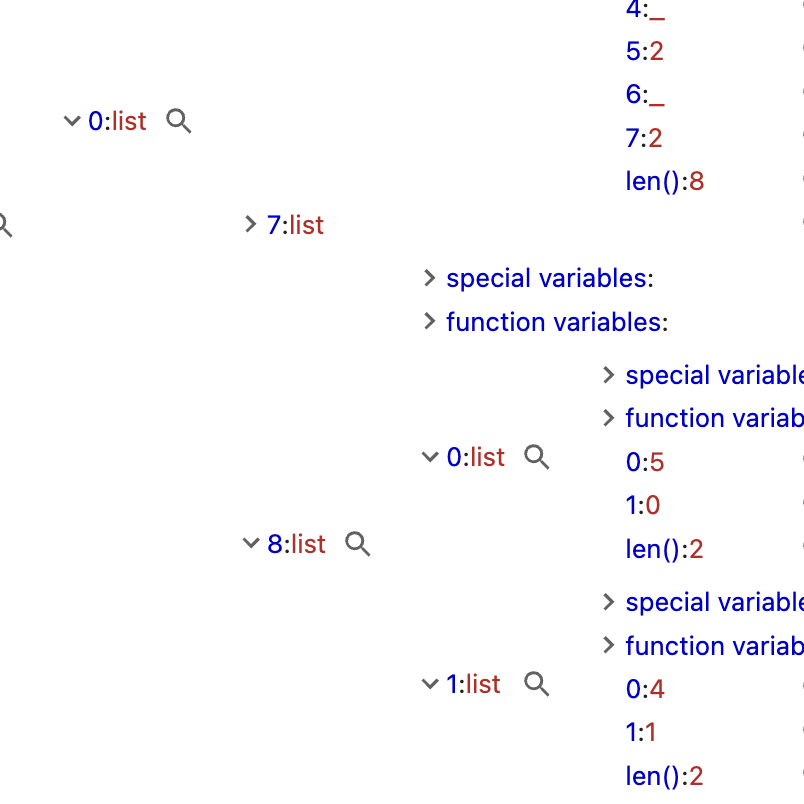